# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)
env.reset()
env.step(1)

Discrete(4)
Discrete(48)


(36, -100, False, {'prob': 1.0})

In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

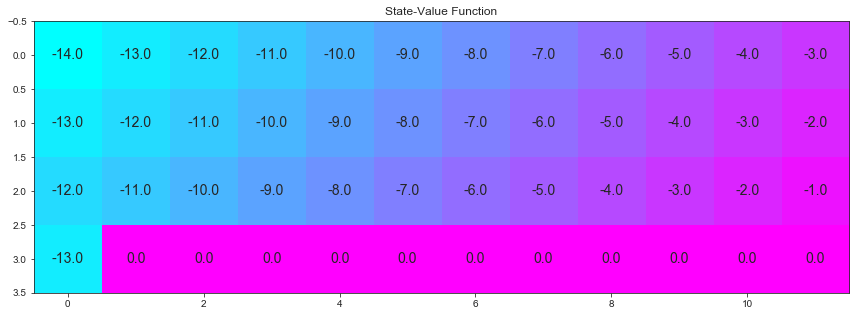

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
import numpy as np
from collections import defaultdict

### This is an agent that lives in a discrete world (finite states), with a finite action space ###
### This is the learner ###

class Agent:

    def __init__(self, action_space, epsilon, gamma, alpha):
        # An np.array with all the possible actions for the agent
        self.actionSpace = action_space
        # This is the agent policy
        self.policy = defaultdict(lambda: np.zeros(len(action_space)))
        # The Q table initied with zeros for all states and actions
        self.QTable = defaultdict(lambda: np.zeros(len(action_space)))
        # The N table initied with zeros for all states and actions
        self.NTable = defaultdict(lambda: np.zeros(len(action_space)))
        # This is the sum of all the returns the agent received over the episode by selecting (state,action)
        self.returns_sum = defaultdict(lambda: np.zeros(len(action_space)))

        # Agent learning parameters
        self.epsilon, self.gamma, self.alpha = epsilon, gamma, alpha

    # Receives a list with (state, action, reward)
    def updateQTable_firstVisitMCPrediction(self, episode):
        """ actualizes the value of QTable according to the First-Visit MC Prediction algorithm """
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            self.returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            self.NTable[state][actions[i]] += 1.0
            self.QTable[state][actions[i]] = self.returns_sum[state][actions[i]] / self.NTable[state][actions[i]]

    def updateQTable_firstVisitMCControl_alphaConstant(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.QTable[state][actions[i]] 
            self.QTable[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

    def updateQTable_Sarsa(self):
        pass
        ## Can not be defined unless we have an standarized way to communicate with the environment
        
    # Receives a row from QTable
    def getProbabilities_egreedyPolicy(self, Q_state):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        # Make an uniform distribution policy for state S and multiply by epsilon to scale it according to the e-greedy policy
        probs_s = np.ones(len(self.actionSpace)) * self.epsilon / len(self.actionSpace)
        # Get the best action according to QTable for state S
        best_a = np.argmax(Q_state)
        # Put probability of best action according to a e-greedy policy
        probs_s[best_a] = 1 - self.epsilon + (self.epsilon / len(self.actionSpace))
        return probs_s

    def updatePolicy(self):
        for state in list(self.QTable.keys()):
            self.policy[state] = np.argmax(self.QTable[state])

    def updateEpsilon(self, epsilon):
        self.epsilon = epsilon

    def actionSpace_sample(self):
        return np.random.choice(self.actionSpace, p=np.ones(len(self.actionSpace))/len(self.actionSpace))

    def decide_egreedy(self, state):
        if state in self.QTable:
            Q_state = self.QTable[state]
            action = np.random.choice(self.actionSpace, p=self.getProbabilities_egreedyPolicy(Q_state))
        else:
            action = self.actionSpace_sample()
        return action


In [6]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    agent = Agent(np.arange(env.action_space.n), epsilon=1, gamma=gamma, alpha=alpha)
    terminal_state = 47
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        agent.updateEpsilon(1/i_episode)
        state = env.reset()
        action = agent.decide_egreedy(state)
        
        while True:
            state_old = state
            action_old = action
            state, reward, boolean, prob = env.step(action_old)
            action = agent.decide_egreedy(state)
            Q_old = agent.QTable[state_old][action_old]
            agent.QTable[state_old][action_old] = Q_old + agent.alpha*(reward + agent.gamma*agent.QTable[state][action] - Q_old)
            
            if state == terminal_state:
                break
                
    return agent.QTable

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  1  1  1  2  1  1  1  2  2  2]
 [ 3  0  1  2  1  1  1  1  2  3  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


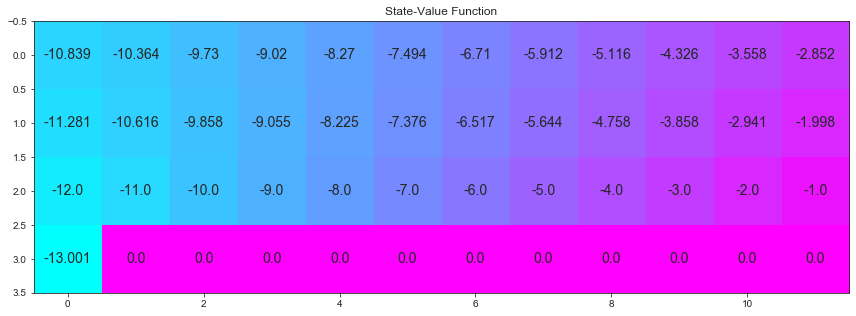

In [7]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [28]:
import numpy as np
from collections import defaultdict

### This is an agent that lives in a discrete world (finite states), with a finite action space ###
### This is the learner ###

class Agent:

    def __init__(self, action_space, epsilon, gamma, alpha):
        # An np.array with all the possible actions for the agent
        self.actionSpace = action_space
        # This is the agent policy
        self.policy = defaultdict(lambda: np.zeros(len(action_space)))
        # The Q table initied with zeros for all states and actions
        self.QTable = defaultdict(lambda: np.zeros(len(action_space)))
        # The N table initied with zeros for all states and actions
        self.NTable = defaultdict(lambda: np.zeros(len(action_space)))
        # This is the sum of all the returns the agent received over the episode by selecting (state,action)
        self.returns_sum = defaultdict(lambda: np.zeros(len(action_space)))

        # Agent learning parameters
        self.epsilon, self.gamma, self.alpha = epsilon, gamma, alpha

    # Receives a list with (state, action, reward)
    def updateQTable_firstVisitMCPrediction(self, episode):
        """ actualizes the value of QTable according to the First-Visit MC Prediction algorithm """
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            self.returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            self.NTable[state][actions[i]] += 1.0
            self.QTable[state][actions[i]] = self.returns_sum[state][actions[i]] / self.NTable[state][actions[i]]

    def updateQTable_firstVisitMCControl_alphaConstant(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.QTable[state][actions[i]] 
            self.QTable[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

    def updateQTable_Sarsa(self):
        pass
        ## Can not be defined unless we have an standarized way to communicate with the environment

    # Receives a row from QTable
    def getProbabilities_egreedyPolicy(self, Q_state):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        # Make an uniform distribution policy for state S and multiply by epsilon to scale it according to the e-greedy policy
        probs_s = np.ones(len(self.actionSpace)) * self.epsilon / len(self.actionSpace)
        # Get the best action according to QTable for state S
        best_a = np.argmax(Q_state)
        # Put probability of best action according to a e-greedy policy
        probs_s[best_a] = 1 - self.epsilon + (self.epsilon / len(self.actionSpace))
        return probs_s

    def updatePolicy(self):
        for state in list(self.QTable.keys()):
            self.policy[state] = np.argmax(self.QTable[state])

    def updateEpsilon(self, epsilon):
        self.epsilon = epsilon

    def actionSpace_sample(self):
        return np.random.choice(self.actionSpace, p=np.ones(len(self.actionSpace))/len(self.actionSpace))

    def decide_egreedy(self, state):
        if state in self.QTable:
            Q_state = self.QTable[state]
            action = np.random.choice(self.actionSpace, p=self.getProbabilities_egreedyPolicy(Q_state))
        else:
            action = self.actionSpace_sample()
        return action

    def decide_greedy(self, state):
        if state in self.QTable:
            Q_state = self.QTable[state]
            action = np.argmax(Q_state)
        else:
            action = self.actionSpace_sample()
        return action

In [29]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    agent = Agent(np.arange(env.action_space.n), epsilon=1, gamma=gamma, alpha=alpha)
    terminal_state = 47
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        agent.updateEpsilon(1/i_episode)
        state = env.reset()
        action = agent.decide_egreedy(state)
        
        while True:
            state_old = state
            action_old = action
            state, reward, boolean, prob = env.step(action_old)
            
            action = agent.decide_greedy(state) # This is only for the max_{a}Q[s][a] computation

            Q_old = agent.QTable[state_old][action_old]
            agent.QTable[state_old][action_old] = Q_old + agent.alpha*(reward + agent.gamma*agent.QTable[state][action] - Q_old)
            action = agent.decide_egreedy(state)
            
            if state == terminal_state:
                break
        
    return agent.QTable

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  1  1  1  1  1  2  2  2  2  0]
 [ 0  1  1  0  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


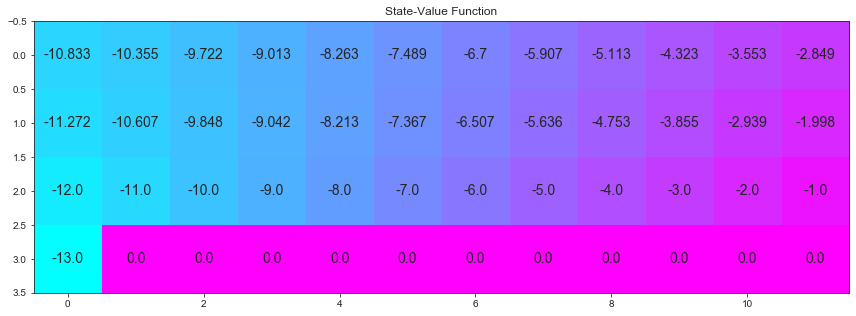

In [30]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [33]:
import numpy as np
from collections import defaultdict

### This is an agent that lives in a discrete world (finite states), with a finite action space ###
### This is the learner ###

class Agent:

    def __init__(self, action_space, epsilon, gamma, alpha):
        # An np.array with all the possible actions for the agent
        self.actionSpace = action_space
        # This is the agent policy
        self.policy = defaultdict(lambda: np.zeros(len(action_space)))
        # The Q table initied with zeros for all states and actions
        self.QTable = defaultdict(lambda: np.zeros(len(action_space)))
        # The N table initied with zeros for all states and actions
        self.NTable = defaultdict(lambda: np.zeros(len(action_space)))
        # This is the sum of all the returns the agent received over the episode by selecting (state,action)
        self.returns_sum = defaultdict(lambda: np.zeros(len(action_space)))

        # Agent learning parameters
        self.epsilon, self.gamma, self.alpha = epsilon, gamma, alpha

    # Receives a list with (state, action, reward)
    def updateQTable_firstVisitMCPrediction(self, episode):
        """ actualizes the value of QTable according to the First-Visit MC Prediction algorithm """
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            self.returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            self.NTable[state][actions[i]] += 1.0
            self.QTable[state][actions[i]] = self.returns_sum[state][actions[i]] / self.NTable[state][actions[i]]

    def updateQTable_firstVisitMCControl_alphaConstant(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.QTable[state][actions[i]] 
            self.QTable[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

    def updateQTable_Sarsa(self):
        pass
        ## Can not be defined unless we have an standarized way to communicate with the environment

    # Receives a row from QTable
    def getProbabilities_egreedyPolicy(self, Q_state):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        # Make an uniform distribution policy for state S and multiply by epsilon to scale it according to the e-greedy policy
        probs_s = np.ones(len(self.actionSpace)) * self.epsilon / len(self.actionSpace)
        # Get the best action according to QTable for state S
        best_a = np.argmax(Q_state)
        # Put probability of best action according to a e-greedy policy
        probs_s[best_a] = 1 - self.epsilon + (self.epsilon / len(self.actionSpace))
        return probs_s

    def updatePolicy(self):
        for state in list(self.QTable.keys()):
            self.policy[state] = np.argmax(self.QTable[state])

    def updateEpsilon(self, epsilon):
        self.epsilon = epsilon

    def actionSpace_sample(self):
        return np.random.choice(self.actionSpace, p=np.ones(len(self.actionSpace))/len(self.actionSpace))

    def decide_egreedy(self, state):
        if state in self.QTable:
            Q_state = self.QTable[state]
            action = np.random.choice(self.actionSpace, p=self.getProbabilities_egreedyPolicy(Q_state))
        else:
            action = self.actionSpace_sample()
        return action

    def decide_greedy(self, state):
        if state in self.QTable:
            Q_state = self.QTable[state]
            action = np.argmax(Q_state)
        else:
            action = self.actionSpace_sample()
        return action

In [39]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    agent = Agent(np.arange(env.action_space.n), epsilon=0.005, gamma=gamma, alpha=alpha)
    terminal_state = 47
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        state = env.reset()
        action = agent.decide_egreedy(state)
        
        while True:
            state_old = state
            action_old = action
            state, reward, boolean, prob = env.step(action_old)
            Q_old = agent.QTable[state_old][action_old]
            
            # As we are using an egreedy policy, the probabilities are 1-eps for selecting the argmax(Q) and eps for
            # selecting a random action. Therefore, expected action is sum(probs[state][a]*Q[state][a] for a in actions).
            expected_value = np.dot(agent.QTable[state], agent.getProbabilities_egreedyPolicy(agent.QTable[state]))
            
            agent.QTable[state_old][action_old] = Q_old + agent.alpha*(reward + agent.gamma*expected_value - Q_old)
            action = agent.decide_egreedy(state)
            
            if state == terminal_state:
                break
        
    return agent.QTable

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  1  2  1  1  0  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


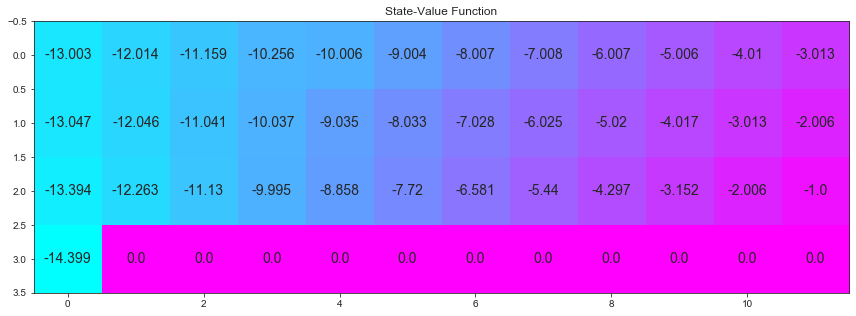

In [40]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])